In [1]:
%matplotlib inline
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import math, sys, os
from numpy.random import randn
from sklearn.datasets import make_blobs

# setup pyspark for IPython_notebooks
spark_home = os.environ.get('SPARK_HOME', None)
sys.path.insert(0, spark_home + "/python")
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home, 'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/

Using Python version 2.7.10 (default, Jul 13 2015 12:05:58)
SparkContext available as sc, HiveContext available as sqlContext.


In [2]:
from sklearn.datasets import make_blobs
from pyspark.mllib.regression import LabeledPoint
# make some data
N = 1000
d = 2
k = 5
sigma = 1
bound = 10*sigma

# symetric, gaussian clusters
X, y = make_blobs(n_samples=N, 
           n_features=d,
           centers=k, 
           cluster_std=sigma, 
           center_box=(-bound, bound), 
           shuffle=True)

# center and sphere data
def center_and_sphere(data_RDD):
    # we can do these stasts steaming in O(n)
    n = float(data_RDD.count())
    arrays = data_RDD.map( lambda t: t[1] )
    mean = arrays.reduce( lambda a, b: a + b ) / n
    vi = lambda x: (x - mean)**2
    std = np.sqrt(arrays.map( vi ).reduce(lambda a, b: a + b) / n)
    normalize = lambda t: (t[0], (t[1] - mean) / std )
    return data_RDD.map(normalize)

data = [(int(y[idx]), row) for idx, row in enumerate(X)]
data_RDD = center_and_sphere(sc.parallelize(data))

# Random projection LSH

In [3]:
def to_binary_string(vec):
    s = ""
    for j in vec:
        if j < 0: 
            s += str(0)
        elif j > 0:
            s += str(1)
        else:
            s += str(0)
    return s
            
def config_random_projection(n_hyperplanes = 5, scale = 2.0, seed = None):
    # random projection vectors
    Z = (np.random.rand(d, n_hyperplanes) - 0.5) * scale
    def projection_func(tup):
        y, x = tup # expect key (int, 1xD vector)
        projs = x.T.dot(Z) # random projections
        bucket = to_binary_string(projs)
        return (bucket, y)
    
    return (Z,projection_func)

Z, hash_func = config_random_projection()

In [4]:
# analyze results
def to_dict(tup):
    bucket, c = tup
    return (bucket, {c: 1})

def reduce_count_clusters(a,b):
    for k, v in a.items():
        if k in b:
            b[k] += v
        else:
            b[k] = v
    return b

def gini_impurity(tup):
    bucket, d = tup
    count = float(sum(d.values()))
    gini = 1 - sum([(float(v) / count)**2 for v in d.values()])
    return (bucket, gini, count)

def weighted_gini(A):
    buckets, ginis, counts = zip(*A)
    N = float(sum(counts))
    return sum([g*(c/N) for g,c in zip(ginis,counts)])
    

In [5]:
gini_impurities = data_RDD.map(hash_func).map(to_dict).reduceByKey(reduce_count_clusters).map(gini_impurity).collect()
for b, g, c in sorted(gini_impurities):
    print "bucket: %s , in bucket: %d , impurity: %f" % (b, c, g)

bucket: 00000 , in bucket: 50 , impurity: 0.000000
bucket: 01000 , in bucket: 297 , impurity: 0.499949
bucket: 01010 , in bucket: 23 , impurity: 0.000000
bucket: 01011 , in bucket: 37 , impurity: 0.306793
bucket: 01111 , in bucket: 158 , impurity: 0.084682
bucket: 10100 , in bucket: 198 , impurity: 0.000000
bucket: 10101 , in bucket: 1 , impurity: 0.000000
bucket: 10111 , in bucket: 80 , impurity: 0.024687
bucket: 11111 , in bucket: 156 , impurity: 0.393491


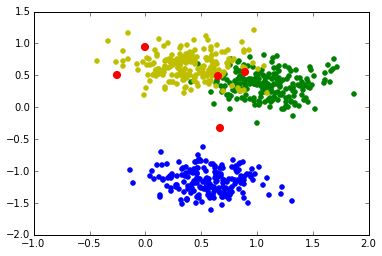

In [7]:
c0 = np.stack(data_RDD.filter(lambda t: t[0] == 0).map(lambda t: t[1]).collect())
c1 = np.stack(data_RDD.filter(lambda t: t[0] == 1).map(lambda t: t[1]).collect())
c2 = np.stack(data_RDD.filter(lambda t: t[0] == 2).map(lambda t: t[1]).collect())

plt.scatter(c0[:,0],c0[:,1],color='g')
plt.scatter(c1[:,0],c1[:,1],color='y')
plt.scatter(c2[:,0],c2[:,1],color='b')
plt.scatter(Z.T[:,0],Z.T[:,1],color='r',s=50)

In [9]:
# impurity as we scale up the number of hyperplanes used for projections

for n_Z in range(10,200,10):
    Z, hash_func = config_random_projection(n_Z)
    gini_impurities = data_RDD.map(hash_func).map(to_dict).reduceByKey(reduce_count_clusters).map(gini_impurity).collect()
    g_i = weighted_gini(gini_impurities)
    print "%d projections: %f" % (n_Z, g_i)
    

10 projections: 0.136161
20 projections: 0.110782
30 projections: 0.074206
40 projections: 0.077499
50 projections: 0.074746
60 projections: 0.067992
70 projections: 0.067539
80 projections: 0.066868
90 projections: 0.059854
100 projections: 0.067434
110 projections: 0.061069
120 projections: 0.063585
130 projections: 0.060988
140 projections: 0.062155
150 projections: 0.060682
160 projections: 0.062039
170 projections: 0.053456
180 projections: 0.056734
190 projections: 0.058580
